# 高斯分布下的运动预测

In [60]:
# namedtuple
from collections import namedtuple
gaussian = namedtuple("Gaussian", ["mean","var"])
gaussian.__repr__ = lambda s: f"N(mean={s[0]:.3f}, var={s[1]:.3f})"

In [61]:
g1 = gaussian(3.4, 10.1)
g2 = gaussian(mean = 4.5, var = 0.2 ** 2)
print(g1)
print(g2)

g1[1], g1[0]
g1.mean, g2.var

N(mean=3.400, var=10.100)
N(mean=4.500, var=0.040)


(3.4, 0.04000000000000001)

In [62]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

In [63]:
pos      = gaussian(10.0, 0.2**2)
movement = gaussian(15.0, 0.7**2)
predict(pos, movement)

N(mean=25.000, var=0.530)

# 高斯分布下的运动观测

In [64]:
def gaussian_multiply(g1, g2):
    mean     = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var) 
    return gaussian(mean, variance)

def update(likelihood, prior):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

predicted_pos = gaussian(10.0, 0.2**2)
measured_pos  = gaussian(11.0, 0.1**2)

estimated_pos = update(predicted_pos, measured_pos)

print(measured_pos)
print(predicted_pos)
print(estimated_pos)

N(mean=11.000, var=0.010)
N(mean=10.000, var=0.040)
N(mean=10.800, var=0.008)


In [65]:
import numpy as np
from numpy.random import randn
from math import sqrt
import matplotlib.pyplot as plt


def print_result(predict, update, z, epoch):

    # 细节暂不需要深究

    # predicted_pos, updated_posclear, measured_pos

    predict_template = '{:3.0f} {: 7.3f} {: 8.3f}'

    update_template  = '\t{: .3f}\t{: 7.3f} {: 7.3f}'

    print(predict_template.format(epoch, predict[0], predict[1]),end='\t')

    print(update_template.format(z, update[0], update[1]))

def plot_result(epochs ,prior_list, x_list, z_list):

    epoch_list = np.arange(epochs)

    plt.plot(epoch_list, prior_list, linestyle=':', color='r',label = "prior/predicted_pos", lw=2)

    plt.plot(epoch_list, x_list, linestyle='-', color='g', label = "posterior/updated_pos",lw=2)

    plt.plot(epoch_list, z_list, linestyle=':', color='b', label = "likelihood/measurement", lw=2)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [66]:
# 1. 一些初始的状态和变量的赋值
motion_var   = 1.0 # 人的运动方差
sensor_var   = 2.0 # GPS的运动方差
x            = gaussian(0, 20**2)
velocity     = 1.0
dt           = 1   # 时间单位的最小刻度
motion_model = gaussian(velocity, motion_var)

# 2.生成数据
zs = []
current_x = x.mean
for _ in range(10): # 我们让小明走10s,每走1s就看看GPS，并且把这些数据存起来
    # 2.1 先生成我们的运动数据
    v = velocity + randn() * motion_var
    current_x += v*dt # 将上一秒的位移加到这一秒

    # 2.2 生成观测数据
    measurement = current_x + randn() * sensor_var # gps观测也有一定误差
    
    zs.append(measurement)

epoch	PREDICT			UPDATE
     	x      var		  z	    x      var
  0   1.000  401.000		 0.227	  0.231   1.990
  1   1.231    2.990		-2.576	 -1.051   1.198
  2  -0.051    2.198		 1.595	  0.811   1.047
  3   1.811    2.047		 3.853	  2.844   1.012
  4   3.844    2.012		 4.863	  4.355   1.003
  5   5.355    2.003		 8.350	  6.854   1.001
  6   7.854    2.001		 4.830	  6.341   1.000
  7   7.341    2.000		 8.781	  8.061   1.000
  8   9.061    2.000		 9.735	  9.398   1.000
  9  10.398    2.000		 11.803	 11.101   1.000

final estimate:                               11.101
actual final estimate:                        11.717


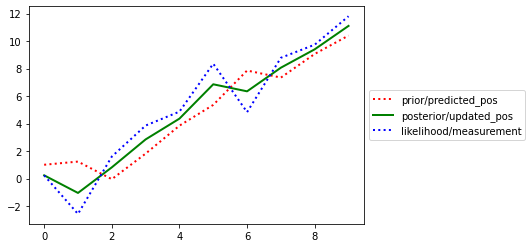

In [67]:
prior_list, x_list, z_list = [],[],[]

print('epoch\tPREDICT\t\t\tUPDATE')

print('     \tx      var\t\t  z\t    x      var')

for epoch, z in enumerate(zs):
    prior = predict(x, motion_model) # 运动预测 # 两个高斯之和
    likelihood = gaussian(z, sensor_var)

    x = update(likelihood, prior)    # 结合观测 # 两个高斯的交集

    print_result(prior, x, z, epoch)
    prior_list.append(prior.mean)
    x_list.append(x.mean)
    z_list.append(z)

print()
print(f"final estimate:       {x.mean:30.3f}")
print(f"actual final estimate:{current_x:30.3f}")

plot_result(10, prior_list, x_list, z_list)


# 卡尔曼增益形式的predict 和 update

In [68]:
def predict(posterior, movement):
    # 上一轮的后验, 其实就是这一轮的一个predict前的分布
    x, P  = posterior
    dx, Q = movment # 一定时间内的位移

    # prediction
    x = x + dx # 高斯之和
    P = P + Q
    return gaussian(x, P)

def update(measurement, prior):
    x, P = prior
    z, R = measurement

    y = z - x
    K = P / (P + R)

    x = x + K * y
    P = (1 - K) * P
    return gaussian(x, P)

# 多元卡尔曼滤波

In [69]:
# refenrence: https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python
from filterpy.common import Q_discrete_white_noise
from kf_book.mkf_internal import plot_all
import math
from scipy.linalg import inv

def compute_person_data(z_var, process_var, count = 1, dt = 1):
    "返回的是我们的track，measurement"
    x, vel = 0., 1.
    z_std  = math.sqrt(z_var)
    p_std  = math.sqrt(process_var)

    xs, zs = [], []

    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt
        z = x + randn() * z_std

        xs.append(x) # predicted position/prior
        zs.append(z) # 观测

    return np.array(xs), np.array(zs)



In [70]:
dt    = 1.0 # 最小时间刻度
R_var = 50  # 测量误差的方差 # 生产设备，进行实验统计而来的
Q_var = 1

x     = np.array([[10.0, 4.5]]).T
P     = np.diag(  [500,   49])

F     = np.array([[1, dt],
                  [0,  1]]) # state transition matrix

H     = np.array([[1., 0]]) # measurement function

R     = np.array([[R_var]])

Q     = Q_discrete_white_noise(dim = 2, dt = dt, var = Q_var)

In [71]:
count = 50
tracks, zs = compute_person_data(R_var, Q_var, count)

xs, cov = [],[]

for z in zs:
    # predict
    x = F @ x
    P = F @ P @ F.T + Q

    # update
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = z - H @ x
    x += K @ y
    P = P - K @ H @ P

    xs.append(x)
    cov.append(P)


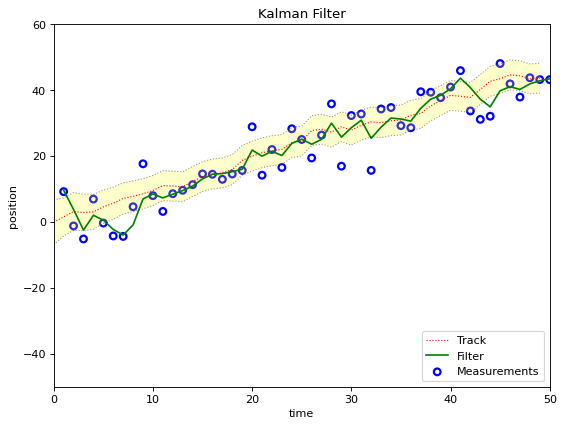

In [72]:
xs, cov = np.array(xs), np.array(cov)

from matplotlib.pyplot import figure
figure(figsize= (8,6), dpi = 80)

plot_all(xs[:,0], tracks, zs, cov, plot_P=False)